<a href="https://colab.research.google.com/github/wikipathways/BioThings_Explorer_PFOCR_clustering/blob/main/bte_clustering_AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment setup

In [99]:
#install the required packages
#!pip install numpy pandas requests requests_cache SetSimilaritySearch fisher

In [132]:
#load packages
from urllib.request import urlopen
import requests
import json
import numpy as np
from copy import copy,deepcopy
import pandas as pd
from fisher import pvalue_npy
# Importing reduce for 
# rolling computations
from functools import reduce

## User Inputs

In [101]:
# which node ID from message.query_graph.nodes should be used for grouping. 
# The entities mapped to that node ID are the "result entities"
# If all then use all the node ids in query
# If specific node id set (e.g. {'MESH:D000068877', 'MESH:D001249'}) then use only these node ids
node_ID_for_grouping = "all"

# n corresponds to the number of results desired
n = 15

# whether clusters must include user-specified node IDs for the subject, the object, both, or neither
# If true then atleast one of the node ids in variable node_ID_for_grouping must be in the result figures
# If false then figures without any of the node ids in variable node_ID_for_grouping are also included
include_user_defined_node_ids = True

## Get BTE TRAPI Results

Master notebook: https://github.com/wikipathways/pathway-figure-ocr/blob/master/notebooks/bte_clustering.ipynb

This notebook reads in the TRAPI results from a URL for the query below.

### Query
Imatinib - [Gene] - Asthma

### Results URL
https://arax.ncats.io/api/arax/v1.3/response/7b14f961-9066-41f7-9e3b-d76b2b4a7fac (83kB, 7 results); "results" in n1

In [117]:
# store the URL in url as parameter for urlopen
#trapi_results_url = "https://arax.ncats.io/api/arax/v1.3/response/7b14f961-9066-41f7-9e3b-d76b2b4a7fac" #7 results
trapi_results_url = "https://arax.ncats.io/api/arax/v1.3/response/49d80ecb-7fd9-4ee6-a642-6d7994903f04" #2862 results

# storing the JSON response from url
with urlopen(trapi_results_url) as url:
    trapi_results_json = json.load(url)

# get the TRAPI results and knowledge graph from the json response
trapi_message = trapi_results_json['message']
trapi_results = trapi_message["results"]
trapi_results_collapsed_df = pd.json_normalize(trapi_results)
trapi_results_collapsed_df

,normalized_score,reasoner_id,score,edge_bindings.e0,edge_bindings.e1,edge_bindings.e2,node_bindings.n0,node_bindings.n1,node_bindings.n2,node_bindings.n3
0,100.000000,BTE,12.185940,"[{'id': '9dc120bb402235c17afb3b2e3b78fb76'}, {...","[{'id': '19c2bb57c287f1846c34571c90aaa96e'}, {...",[{'id': 'c7a31c81a608b37d4b3c780a120bbe45'}],[{'id': 'PUBCHEM.COMPOUND:123596'}],[{'id': 'NCBIGene:25'}],[{'id': 'NCBIGene:613'}],[{'id': 'HP:0002099'}]
1,99.965059,BTE,10.565239,"[{'id': '9dc120bb402235c17afb3b2e3b78fb76'}, {...",[{'id': 'a729758322e7ed6b1e662320f159930c'}],"[{'id': '97c08a16970fcd05971ada2697b7e4c6'}, {...",[{'id': 'PUBCHEM.COMPOUND:123596'}],[{'id': 'NCBIGene:25'}],[{'id': 'NCBIGene:154'}],[{'id': 'HP:0002099'}]
2,99.930119,BTE,8.948994,"[{'id': '9dc120bb402235c17afb3b2e3b78fb76'}, {...","[{'id': '0ab283b0c145cede3da65288cf41f5e3'}, {...","[{'id': '607b4519f71bb810f7251c14a3f9b2c2'}, {...",[{'id': 'PUBCHEM.COMPOUND:123596'}],[{'id': 'NCBIGene:25'}],[{'id': 'NCBIGene:7124'}],[{'id': 'HP:0002099'}]
3,99.895178,BTE,8.403776,"[{'id': '9dc120bb402235c17afb3b2e3b78fb76'}, {...","[{'id': '6d800d9b9d88a16396935fff0c448957'}, {...","[{'id': 'facdce5b3a16f7648de732e39fbfbf5f'}, {...",[{'id': 'PUBCHEM.COMPOUND:123596'}],[{'id': 'NCBIGene:25'}],[{'id': 'NCBIGene:6776'}],[{'id': 'HP:0002099'}]
4,99.860238,BTE,8.401063,"[{'id': '9dc120bb402235c17afb3b2e3b78fb76'}, {...",[{'id': 'bb7f943831ff7ba5ea8ce5cdf2e345bd'}],[{'id': '120e4972df69ae731d6312f2b4e2b795'}],[{'id': 'PUBCHEM.COMPOUND:123596'}],[{'id': 'NCBIGene:25'}],[{'id': 'UniProtKB:P01585'}],[{'id': 'HP:0002099'}]
...,...,...,...,...,...,...,...,...,...,...
2857,11.250874,BTE,0.000000,[{'id': '47b528f4619fe13a988467e04b78b536'}],[{'id': '0658b9b1928e12f17428a071176f16d7'}],[{'id': '0dd0a3b71439e29b7c95313738f0f6d6'}],[{'id': 'PUBCHEM.COMPOUND:123596'}],[{'id': 'NCBIGene:3725'}],[{'id': 'NCBIGene:5270'}],[{'id': 'HP:0002099'}]
2858,11.250874,BTE,0.000000,[{'id': '47b528f4619fe13a988467e04b78b536'}],[{'id': '437afad8e33630da291d38455fd1589f'}],[{'id': '921dce4fb67dfc8fdbc79a31b54f0777'}],[{'id': 'PUBCHEM.COMPOUND:123596'}],[{'id': 'NCBIGene:3725'}],[{'id': 'NCBIGene:4171'}],[{'id': 'HP:0002099'}]
2859,11.250874,BTE,0.000000,[{'id': '47b528f4619fe13a988467e04b78b536'}],[{'id': 'e8cd85fe231999bcd49900555ea92437'}],[{'id': '822825216658be309d0a2c682ca61ddb'}],[{'id': 'PUBCHEM.COMPOUND:123596'}],[{'id': 'NCBIGene:3725'}],[{'id': 'NCBIGene:23038'}],[{'id': 'HP:0002099'}]
2860,11.250874,BTE,0.000000,[{'id': '47b528f4619fe13a988467e04b78b536'}],[{'id': '7104e379f43471703d14c8f2a4242ef1'}],[{'id': '94416892a9fd677acf3c9d3c64b529e7'}],[{'id': 'PUBCHEM.COMPOUND:123596'}],[{'id': 'NCBIGene:3725'}],[{'id': 'NCBIGene:5971'}],[{'id': 'HP:0002099'}]


## Create a dataframe with expanded TRAPI results
  
The final dataframe is called ```trapi_results_df```

In [118]:
# NOTE: we're including categories specified in the query template
# in the next cell, and in a cell further down, we're also including
# any categories from the TRAPI results.
#
# TODO: Some categories are supersets of others. Should we handle
# this systematically?

# get the query graph from the TRAPI results
query = trapi_message["query_graph"]

curie_categories = set()
for v in query["nodes"].values():
    if "categories" in v:
        for category in v["categories"]:
            curie_categories.add(category)

In [119]:
# for genes/gene products, chemicals and diseases
# we need to resolve the CURIES as PFOCR data has only mesh ids and NCBI gene ids
preferred_prefixes = set(["NCBIGene", "MESH"])
trapi_results_unified_curies = set()
unification_failed_curies = set()
unified_prefixes = set()
all_prefixes = set()
curie_to_name = dict()
curie_to_categories = dict()
curie_to_unified_curie = dict()
for k, v in trapi_message["knowledge_graph"]["nodes"].items():
    name = v["name"]
    categories = v["categories"]
    curie_categories |= set(categories)

    for a in v["attributes"]:
        if a["attribute_type_id"] == "biolink:xref":
            curies = a["value"]

            # k should always be one of the curies
            if not k in curies:
                raise Exception(f"key {k} not in {curies}")

            unified_curie = None
            intersecting_trapi_results_unified_curies = trapi_results_unified_curies.intersection(
                set(curies)
            )
            if len(intersecting_trapi_results_unified_curies) > 1:
                multiple_matches = list(intersecting_trapi_results_unified_curies)
                raise Exception(f"matching multiple: {k} to {multiple_matches}")
            elif len(intersecting_trapi_results_unified_curies) == 1:
                unified_curie = list(intersecting_trapi_results_unified_curies)[0]
            else:
                # get curie for preferred prefix. usually this is k, but not always.
                for curie in curies:
                    [prefix, identifier] = curie.split(":")
                    if prefix in preferred_prefixes:
                        unified_curie = curie
                        trapi_results_unified_curies.add(unified_curie)
                        break

            if not unified_curie:
                if k in curie_to_unified_curie:
                    unified_curie = curie_to_unified_curie[k]
                else:
                    unification_failed_curies.add(k)
                    break

                #raise Exception(f"failed to find a unified curie for {k} in {curies}")

            [unified_prefix, unified_identifier] = unified_curie.split(":")
            unified_prefixes.add(unified_prefix)

            for curie in curies:
                [prefix, identifier] = curie.split(":")
                all_prefixes.add(prefix)
                if not curie in curie_to_unified_curie:
                    curie_to_unified_curie[curie] = unified_curie
                if not curie in curie_to_name:
                    curie_to_name[curie] = name
                    curie_to_categories[curie] = categories
                elif curie_to_name[curie] != name:
                    print(f"curie {curie} has multiple primary names: {curie_to_name[curie]} and {name}")
                    #raise Exception(f"curie{curie} has multiple names: {curie_to_name[curie]} and {name}")


#print(f'curie_categories: {curie_categories}')
#print("")
#print(f"curie_to_name key count: {len(curie_to_name.keys())}")
#print(f"curie_to_unified_curie key count: {len(curie_to_unified_curie.keys())}")
#print("")
print("all CURIE prefixes found:")
print(all_prefixes)
print("")
print("unified CURIE prefixes found:")
print(unified_prefixes)
print("")
print(f"failed to unify {len(unification_failed_curies)} CURIEs")

all CURIE prefixes found:
{'DrugCentral', 'UNII', 'SNOMEDCT', 'PUBCHEM.COMPOUND', 'DRUGBANK', 'HP', 'MEDDRA', 'UniProtKB', 'CHEBI', 'CAS', 'HGNC', 'MESH', 'INCHIKEY', 'PR', 'NCIT', 'NCBIGene', 'ENSEMBL', 'OMIM', 'CHEMBL.COMPOUND', 'UMLS'}

unified CURIE prefixes found:
{'MESH', 'NCBIGene'}

failed to unify 82 CURIEs


In [120]:
#preparing dataframe columns
columns = []
q_node_id_keys = set(["object", "subject"])
q_node_ids = []
q_edge_ids = []
for q_edge_id,edge_v in query["edges"].items():
    q_edge_ids.append(q_edge_id)
    q_node_id_found = False
    for k,v in edge_v.items():
        if (k in q_node_id_keys) and (type(v) is str):
            if v not in columns:
                q_node_ids.append(v)
                columns.append(v)
            if not q_node_id_found:
                q_node_id_found = True
                columns.append(q_edge_id)

query_nodes_with_ids = set()
for k, v in query['nodes'].items():
    node_ids = v.get('ids', [])
    if node_ids:
        query_nodes_with_ids.add(k)

for q_node_id in q_node_ids:
    columns.append(f"{q_node_id}_original_curie")
    columns.append(f"{q_node_id}_unified_curie")

columns.append("unified_curie_set")

trapi_result_columns = []
for i in range(len(q_node_ids)):
    trapi_result_columns.append(q_node_ids[i])
    if i < len(q_edge_ids):
        trapi_result_columns.append(q_edge_ids[i])

unified_curie_columns = []
for q_node_id in q_node_ids:
    unified_curie_columns.append(f"{q_node_id}_unified_curie")
    
columns

['n1',
 'e0',
 'n0',
 'n2',
 'e1',
 'n3',
 'e2',
 'n1_original_curie',
 'n1_unified_curie',
 'n0_original_curie',
 'n0_unified_curie',
 'n2_original_curie',
 'n2_unified_curie',
 'n3_original_curie',
 'n3_unified_curie',
 'unified_curie_set']

In [121]:
#fill-in edge information from the knowledge graph 

#might be useful to explore later for filtering strategie, e.g., ignore certain edge types?
#or might be unnecessary?

result_row_data = []
for trapi_result in trapi_results:
    curie_to_qnode_ids = dict()
    for qnode_id, entries in trapi_result["node_bindings"].items():
        for entry in entries:
            curie = entry["id"]
            if curie not in curie_to_qnode_ids:
                curie_to_qnode_ids[curie] = []
            curie_to_qnode_ids[curie].append(qnode_id)

    row_data_template = dict()
    q_edge_id_to_predicates = dict()
    trapi_result_curie_set = set()
    for qedge_id, entries in trapi_result["edge_bindings"].items():
        for entry in entries:
            curie = entry["id"]
            kg_entry = trapi_message["knowledge_graph"]["edges"][curie]
            subject_curie = kg_entry["subject"]
            object_curie = kg_entry["object"]
            predicate_curie = kg_entry["predicate"]
            [predicate_prefix, predicate_identifier] = predicate_curie.split(":")

            if qedge_id not in q_edge_id_to_predicates:
                q_edge_id_to_predicates[qedge_id] = set()
            q_edge_id_to_predicates[qedge_id].add(predicate_identifier)

            for curie in [subject_curie, object_curie]:
                for qnode_id in curie_to_qnode_ids[curie]:
                    if curie in curie_to_unified_curie:
                        unified_curie = curie_to_unified_curie[curie]
                    else:
                        break

                    name = curie_to_name[curie]
                    row_data_template[qnode_id] = name

                    trapi_result_curie_set.add(unified_curie)
                    row_data_template[qnode_id + "_original_curie"] = curie
                    row_data_template[qnode_id + "_unified_curie"] = unified_curie

    if len(trapi_result_curie_set) != len(q_node_ids):
        #print(f'skipping {list(curie_to_qnode_ids.keys())}')
        continue

    row_data_template["unified_curie_set"] = trapi_result_curie_set
    q_edge_ids_processed = set()
    row_datas = [row_data_template]
    for q_edge_id,predicates in q_edge_id_to_predicates.items():
        next_row_datas = []
        for row_data in row_datas:
            for predicate in predicates:
                next_row_data = deepcopy(row_data)
                next_row_data[q_edge_id] = predicate
                next_row_datas.append(
                    next_row_data 
                )
        row_datas = next_row_datas
    result_row_data += row_datas

print("warning: predicate direction(s) may be switched")
trapi_results_df = pd.DataFrame.from_records(result_row_data, columns=columns)
trapi_results_collapsed_df = trapi_results_df.drop(columns=['e0', 'e1']).drop_duplicates(subset=['n1', 'n0', 'n2'])

trapi_results_df
#trapi_results_collapsed_df

,n1,e0,n0,n2,e1,n3,e2,n1_original_curie,n1_unified_curie,n0_original_curie,n0_unified_curie,n2_original_curie,n2_unified_curie,n3_original_curie,n3_unified_curie,unified_curie_set
0,ABL1,decreases_molecular_modification_of,Imatinib mesylate,BCR,entity_positively_regulated_by_entity,Asthma,associated_with,NCBIGene:25,NCBIGene:25,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:613,NCBIGene:613,HP:0002099,MESH:D001249,"{NCBIGene:613, MESH:D000068877, NCBIGene:25, M..."
1,ABL1,decreases_molecular_modification_of,Imatinib mesylate,BCR,produced_by,Asthma,associated_with,NCBIGene:25,NCBIGene:25,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:613,NCBIGene:613,HP:0002099,MESH:D001249,"{NCBIGene:613, MESH:D000068877, NCBIGene:25, M..."
2,ABL1,decreases_molecular_modification_of,Imatinib mesylate,BCR,entity_negatively_regulates_entity,Asthma,associated_with,NCBIGene:25,NCBIGene:25,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:613,NCBIGene:613,HP:0002099,MESH:D001249,"{NCBIGene:613, MESH:D000068877, NCBIGene:25, M..."
3,ABL1,decreases_molecular_modification_of,Imatinib mesylate,BCR,physically_interacts_with,Asthma,associated_with,NCBIGene:25,NCBIGene:25,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:613,NCBIGene:613,HP:0002099,MESH:D001249,"{NCBIGene:613, MESH:D000068877, NCBIGene:25, M..."
4,ABL1,decreases_molecular_modification_of,Imatinib mesylate,BCR,entity_negatively_regulated_by_entity,Asthma,associated_with,NCBIGene:25,NCBIGene:25,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:613,NCBIGene:613,HP:0002099,MESH:D001249,"{NCBIGene:613, MESH:D000068877, NCBIGene:25, M..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14636,JUN,increases_activity_of,Imatinib mesylate,SERPINE2,entity_negatively_regulated_by_entity,Asthma,contributes_to,NCBIGene:3725,NCBIGene:3725,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:5270,NCBIGene:5270,HP:0002099,MESH:D001249,"{NCBIGene:5270, NCBIGene:3725, MESH:D000068877..."
14637,JUN,increases_activity_of,Imatinib mesylate,MCM2,entity_regulates_entity,Asthma,occurs_together_in_literature_with,NCBIGene:3725,NCBIGene:3725,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:4171,NCBIGene:4171,HP:0002099,MESH:D001249,"{MESH:D001249, NCBIGene:3725, NCBIGene:4171, M..."
14638,JUN,increases_activity_of,Imatinib mesylate,WDTC1,entity_regulates_entity,Asthma,occurs_together_in_literature_with,NCBIGene:3725,NCBIGene:3725,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:23038,NCBIGene:23038,HP:0002099,MESH:D001249,"{NCBIGene:3725, NCBIGene:23038, MESH:D00006887..."
14639,JUN,increases_activity_of,Imatinib mesylate,RELB,entity_regulates_entity,Asthma,occurs_together_in_literature_with,NCBIGene:3725,NCBIGene:3725,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:5971,NCBIGene:5971,HP:0002099,MESH:D001249,"{MESH:D001249, NCBIGene:3725, NCBIGene:5971, M..."


## Identify result entities using user specified parameters

```node_ID_for_grouping``` variable defines which node ID(s) from message.query_graph.nodes should be used for grouping. The entities mapped to that node ID are the "result entities". If "all" then use all the node ids in query are used. If specific node id set (e.g. {'MESH:D000068877', 'MESH:D001249'}), then use only these node ids are used.

In [122]:
print("Unique CURIE count per query node:")
for q_node_id in q_node_ids:
    print(f'{q_node_id}: {len(set(trapi_results_df[q_node_id]))}')

Unique CURIE count per query node:
n1: 24
n0: 1
n2: 568
n3: 1


In [123]:
#get all nodes with ids from the query 
user_specified_ids = set()
for query_node in query_nodes_with_ids:
    user_specified_ids.update(trapi_results_df[f'{query_node}_unified_curie'].tolist())
user_specified_ids

{'MESH:D000068877', 'MESH:D001249'}

In [124]:
# identify node ids for identifying result entities
if(node_ID_for_grouping != "all"):
    user_specified_ids = user_specified_ids.intersection(node_ID_for_grouping)

user_specified_ids

{'MESH:D000068877', 'MESH:D001249'}

## Get PFOCR Data

Get PFOCR data from Dropbox.

In [125]:
# read in figure metadata for all PFOCR figures
figure_metadata_df = pd.read_csv('https://www.dropbox.com/s/9jorbzpq2k8n5tr/figures_metadata.csv?dl=1', index_col=0)
figure_metadata_df

,figure_url,figure_title
figure_id,,
PMC5732092__cshperspect-CYT-028522_F2.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,Interleukin (IL)-17RA/RC signaling pathways
PMC5793760__cshperspect-TGF-022210_F4.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,TGFB signaling pathways
PMC5793761__cshperspect-TGF-031989_F1.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,Bone morphogenetic protein (BMP) signaling pat...
PMC5830892__cshperspect-CEL-027961_F2.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,FERM-binding partners of Crumbs3
PMC5830900__cshperspect-TGF-031997_F1.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,Role of the TGFB family in mammary gland devel...
...,...,...
PMC2804790__253_2009_2262_Fig1_HTML.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,Ehrlich degradation pathway from amino acid to...
PMC6332787__thnov09p0126g006.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,Illustration of the mechanisms underlying LPD ...
PMC5807036__IJO-52-03-0787-g01.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,Tumorigenic proteins significantly upregulated...


In [126]:
# read in figure CURIES for all PFOCR figures
figure_curie_df = pd.read_csv('https://www.dropbox.com/s/y3ks74obs3nrjjz/figures_curie.csv?dl=1')
figure_curie_df

,figure_id,curie,category
0,PMC5732092__cshperspect-CYT-028522_F2.jpg,NCBIGene:5601,gene
1,PMC5732092__cshperspect-CYT-028522_F2.jpg,NCBIGene:5595,gene
2,PMC5732092__cshperspect-CYT-028522_F2.jpg,NCBIGene:1051,gene
3,PMC5732092__cshperspect-CYT-028522_F2.jpg,NCBIGene:10131,gene
4,PMC5732092__cshperspect-CYT-028522_F2.jpg,NCBIGene:23765,gene
...,...,...,...
1665596,PMC4609065__12885_2015_1721_Fig5_HTML.jpg,NCBIGene:1956,gene
1665597,PMC4609065__12885_2015_1721_Fig5_HTML.jpg,NCBIGene:4893,gene
1665598,PMC4609065__12885_2015_1721_Fig5_HTML.jpg,NCBIGene:2064,gene
1665599,PMC4609065__12885_2015_1721_Fig5_HTML.jpg,NCBIGene:3845,gene


## Enrichment/grouping of TRAPI results using PFOCR figures

We identify the top PFOCR figures by iteratively running Fisher's Exact Test to identify PFOCR figures that are most similar to all the CURIEs from the BTE TRAPI results. To get each cluster figure, we do the following:

1. Run Fisher's Exact Test for the CURIEs from each figure vs. the set of the unique CURIEs found from all the TRAPI results, limiting each  set of CURIEs to those with categories found in both PFOCR and BTE TRAPI, e.g., "disease" is found in PFOCR and "biolink:Disease" is found in BTE TRAPI
2. Select the figure with the lowest p-value as a cluster figure
3. Exclude that figure and the CURIEs in it
4. Repeat to get the next cluster figure, continuing until:
    - we run out of BTE TRAPI results
    - we run out of PFOCR figures
    - we've repeated steps 1-3 a user-defined number of times (varibale ```n```)

In [127]:
# find the corresponding PFOCR category for a biolink category
biolink_category_to_pfocr_category = {
    "biolink:Drug": "chemical",
    "biolink:ChemicalEntity": "chemical",
    "biolink:SmallMolecule": "chemical",
    "biolink:Disease": "disease",
    "biolink:DiseaseOrPhenotypicFeature": "disease",
    "biolink:Gene": "gene",
    "biolink:GeneProduct": "gene",
    "biolink:Protein": "gene",
}

# limit to categories returned from query
relevant_biolink_categories = set(biolink_category_to_pfocr_category.keys()).intersection(curie_categories)
relevant_pfocr_categories = set([
    biolink_category_to_pfocr_category[
        biolink_category
    ] for biolink_category in relevant_biolink_categories
])

In [128]:
def set_union(series):
    return reduce(lambda x, y: x | y, series)

def create_set(series):
    return set(series.tolist())


# TODO: remove cluster_figure_data and its associated DF.
# It's just a temporary thing to show what's happening inside.
cluster_figure_data = []
def get_next_cluster_figures(
    category_matched_pfocr_curie_count,
    remaining_figures_df,
    remaining_trapi_curie_count,
    required_curies,
    iteration_limit=n, #this is the user-defined parameter for the number of figures
    i=0,
    cluster_figure_ids=[],
):
    remaining_figure_count = len(
        remaining_figures_df
    )

    if (
        i >= iteration_limit
    ) or (
        len(remaining_trapi_curie_count) == 0
    ) or (
        remaining_figure_count == 0
    ):
        return cluster_figure_ids
    
    remaining_figures_df["figure_curie_count"] = remaining_figures_df["curie_set"].map(len)

    remaining_figures_df["figure_curies_in_trapi_results"] = remaining_figures_df["curie_set"].map(
        lambda curie_set: remaining_trapi_curie_count.intersection(
            set(curie_set)
        )
    )

    # number of CURIEs in both TRAPI results and figure
    remaining_figures_df["yes_trapi_results_yes_figure"] = remaining_figures_df[
        "figure_curies_in_trapi_results"
    ].map(len)

    # number of CURIEs in TRAPI results but not in figure
    remaining_figures_df["yes_trapi_results_no_figure"] = (
        len(remaining_trapi_curie_count) -
        remaining_figures_df["yes_trapi_results_yes_figure"]
    )

    # number of CURIEs not in TRAPI results but in figure
    remaining_figures_df["no_trapi_results_yes_figure"] = (
        remaining_figures_df["figure_curie_count"] -
        remaining_figures_df["yes_trapi_results_yes_figure"]
    )

    # number of CURIEs not in TRAPI results and not in figure,
    # ie., number of unique CURIEs only in other figures
    remaining_figures_df["no_trapi_results_no_figure"] = (
        category_matched_pfocr_curie_count -
        len(remaining_trapi_curie_count) -
        remaining_figures_df["no_trapi_results_yes_figure"]
    )

    # see https://stackoverflow.com/a/58661068/5354298
    _, _, twosided = pvalue_npy(
        remaining_figures_df["yes_trapi_results_yes_figure"].to_numpy('uint'),
        remaining_figures_df["yes_trapi_results_no_figure"].to_numpy('uint'),
        remaining_figures_df["no_trapi_results_yes_figure"].to_numpy('uint'),
        remaining_figures_df["no_trapi_results_no_figure"].to_numpy('uint'),
    )

    remaining_figures_df["p_value"] = pd.Series(twosided, index=remaining_figures_df.index)
    remaining_figures_df["p_value"].sort_values()
    
    min_df = remaining_figures_df[
        remaining_figures_df["p_value"] == remaining_figures_df["p_value"].min()
    ]
    
    if required_curies:
        # TODO: it might make sense to keep prioritizing the required CURIEs, but
        #       it's not clear whether this is always what we want.
        #       In some cases, we could obscure a different set of results that may
        #       be valuable but not because of the overlap with the required CURIEs.
        curies_to_exclude = set(
            min_df["figure_curies_in_trapi_results"].agg(set_union)
        ) - required_curies
    else:
        curies_to_exclude = set(min_df["figure_curies_in_trapi_results"].agg(set_union))
        
    if len(curies_to_exclude - required_curies) == 0:
        # On this iteration, we failed to match any new CURIE(s), other than
        # possibly just the require CURIEs.
        return cluster_figure_ids
        
    new_cluster_figure_ids = min_df.index.tolist()
    cluster_figure_ids.extend(new_cluster_figure_ids)
    
    next_min_df_score = remaining_figures_df[
        remaining_figures_df["p_value"] > remaining_figures_df["p_value"].min()
    ]["p_value"].min()
    next_min_df = remaining_figures_df[remaining_figures_df["p_value"] == next_min_df_score]
    
    for cluster_figure_id, min_row in min_df.iterrows():
        cluster_figure_data.append({
            "iteration": i,
            "figure_id": cluster_figure_id,
            "p_value": min_row["p_value"],
            "next_best_figure_ids": next_min_df.index.tolist(),
            "next_best_p_value": next_min_df["p_value"].min(),
            "yes_trapi_results_yes_figure": min_row["yes_trapi_results_yes_figure"],
            "yes_trapi_results_no_figure": min_row["yes_trapi_results_no_figure"],
            "no_trapi_results_yes_figure": min_row["no_trapi_results_yes_figure"],
            "no_trapi_results_no_figure": min_row["no_trapi_results_no_figure"],
            "figure_curies_in_trapi_results": min_row["figure_curies_in_trapi_results"],
            "curie_set": min_row["curie_set"],
            "curies_to_exclude": curies_to_exclude,
            "len_curies_to_exclude": len(curies_to_exclude),
            "remaining_figure_count": remaining_figure_count,
            "remaining_trapi_curie_count": len(remaining_trapi_curie_count),
            "cluster_figure_id_count": len(cluster_figure_ids),
        })
    
    # for next iteration, exclude figures we've already added to cluster figures
    next_remaining_figures_df = remaining_figures_df[
        (~remaining_figures_df.index.isin(
            cluster_figure_ids
        ))
    ]
    
    print(
        f'iteration {i:>2}: figures: {len(new_cluster_figure_ids):>2}, CURIEs: {len(curies_to_exclude):>2}'
    )
    
    return get_next_cluster_figures(
        category_matched_pfocr_curie_count,
        next_remaining_figures_df.reset_index().set_index("figure_id"),
        remaining_trapi_curie_count - curies_to_exclude,
        required_curies,
        iteration_limit,
        i + 1,
        cluster_figure_ids,
    )

category_matched_figure_curie_df = figure_curie_df[figure_curie_df["category"].isin(
    list(relevant_pfocr_categories)
)]
category_matched_pfocr_curie_count = len(set(
    category_matched_figure_curie_df["curie"].drop_duplicates()
))
print(f'category_matched_pfocr_curie_count: {category_matched_pfocr_curie_count}')

category_matched_figures_df = category_matched_figure_curie_df[
    ["figure_id", "curie"]
].groupby("figure_id").agg(
    create_set
).rename(columns={
    "curie": "curie_set"
})

category_matched_figures_df["figure_curies_in_trapi_results_count"] = category_matched_figures_df[
    "curie_set"
].map(
    lambda curie_set: len(trapi_results_unified_curies.intersection(
        set(curie_set)
    ))
)

overlapping_category_matched_figures_df = category_matched_figures_df[
    category_matched_figures_df["figure_curies_in_trapi_results_count"] > 0
]

# Require that cluster figures have specific user-specified CURIEs
if include_user_defined_node_ids:
    required_curies = user_specified_ids
if required_curies:
    overlapping_category_matched_figures_df = overlapping_category_matched_figures_df[
        overlapping_category_matched_figures_df["curie_set"].map(
            # require all of them
            # lambda curie_set: len(curie_set.intersection(required_curies)) == len(required_curies)
            # require at least one of them
            lambda curie_set: len(curie_set.intersection(required_curies)) > 0
        )
    ]

cluster_figure_ids_out = get_next_cluster_figures(
    category_matched_pfocr_curie_count,
    overlapping_category_matched_figures_df.reset_index().set_index("figure_id"),
    trapi_results_unified_curies,
    required_curies,
)
print(f'cluster figure count: {len(cluster_figure_ids_out)}')
cluster_figure_df = pd.DataFrame.from_records(cluster_figure_data)
cluster_figure_df

category_matched_pfocr_curie_count: 30163
iteration  0: figures:  1, CURIEs: 11
iteration  1: figures:  1, CURIEs:  8
iteration  2: figures:  1, CURIEs:  9
iteration  3: figures:  1, CURIEs: 22
iteration  4: figures:  3, CURIEs: 49
iteration  5: figures:  1, CURIEs: 50
iteration  6: figures:  1, CURIEs: 17
cluster figure count: 9


,iteration,figure_id,p_value,next_best_figure_ids,next_best_p_value,yes_trapi_results_yes_figure,yes_trapi_results_no_figure,no_trapi_results_yes_figure,no_trapi_results_no_figure,figure_curies_in_trapi_results,curie_set,curies_to_exclude,len_curies_to_exclude,remaining_figure_count,remaining_trapi_curie_count,cluster_figure_id_count
0,0,PMC4346735__zh00051576930001.jpg,4.196121e-08,[PMC7023894__nihms-1556086-f0004.jpg],8.091146e-08,12,575,7,29569,"{MESH:D001249, NCBIGene:920, NCBIGene:50943, N...","{MESH:D001249, NCBIGene:7124, NCBIGene:6955, N...","{NCBIGene:920, NCBIGene:50943, NCBIGene:7048, ...",11,9,587,1
1,1,PMC7023894__nihms-1556086-f0004.jpg,7.235480e-08,[PMC3606047__nihms438583f1.jpg],8.231677e-08,9,567,4,29583,"{MESH:D001249, NCBIGene:59, NCBIGene:4659, NCB...","{MESH:D001249, NCBIGene:59, NCBIGene:4659, NCB...","{NCBIGene:59, NCBIGene:4659, NCBIGene:71, NCBI...",8,8,576,2
2,2,PMC3606047__nihms438583f1.jpg,7.484704e-08,[PMC8065335__41392_2021_568_Fig5_HTML.jpg],1.380675e-07,10,558,11,29584,"{MESH:D001249, NCBIGene:134, NCBIGene:135, NCB...","{MESH:D001249, MESH:D058186, MESH:D008103, MES...","{NCBIGene:134, NCBIGene:135, NCBIGene:196, NCB...",9,7,568,3
3,3,PMC8065335__41392_2021_568_Fig5_HTML.jpg,1.222266e-07,"[PMC4100143__ijms-15-10116-g001.jpg, PMC586685...",3.184320e-07,23,536,10,29594,"{MESH:D001249, NCBIGene:6372, NCBIGene:6374, N...","{MESH:D001249, MESH:D009336, NCBIGene:6372, NC...","{NCBIGene:6372, NCBIGene:6374, NCBIGene:5971, ...",22,6,559,4
4,4,PMC4100143__ijms-15-10116-g001.jpg,2.348934e-07,[PMC4973429__fphar-07-00237-g0002.jpg],4.464558e-07,22,515,15,29611,"{NCBIGene:3605, MESH:D001249, NCBIGene:3586, N...","{NCBIGene:3605, MESH:D001249, NCBIGene:6773, N...","{NCBIGene:3605, NCBIGene:7357, NCBIGene:55331,...",49,5,537,7
5,4,PMC5866851__MI2018-3858032.002.jpg,2.348934e-07,[PMC4973429__fphar-07-00237-g0002.jpg],4.464558e-07,23,514,14,29612,"{MESH:D001249, NCBIGene:5600, NCBIGene:6352, N...","{MESH:D001249, NCBIGene:5600, NCBIGene:27111, ...","{NCBIGene:3605, NCBIGene:7357, NCBIGene:55331,...",49,5,537,7
6,4,PMC6399501__475fig1.jpg,2.348934e-07,[PMC4973429__fphar-07-00237-g0002.jpg],4.464558e-07,8,529,29,29597,"{NCBIGene:7357, MESH:D001249, NCBIGene:55331, ...","{NCBIGene:7357, MESH:D001249, NCBIGene:2583, M...","{NCBIGene:3605, NCBIGene:7357, NCBIGene:55331,...",49,5,537,7
7,5,PMC6556902__bby025f2.jpg,1.866757e-07,[PMC4973429__fphar-07-00237-g0002.jpg],2.164246e-07,51,437,19,29656,"{MESH:D001249, NCBIGene:55620, NCBIGene:5728, ...","{MESH:D001249, NCBIGene:57172, NCBIGene:55620,...","{NCBIGene:55620, NCBIGene:5728, NCBIGene:9575,...",50,2,488,8
8,6,PMC4973429__fphar-07-00237-g0002.jpg,9.495583e-08,[],NaN,18,420,22,29703,"{NCBIGene:2354, MESH:D001249, NCBIGene:23236, ...","{MESH:D005947, MESH:D001249, NCBIGene:5332, NC...","{NCBIGene:5332, NCBIGene:3726, NCBIGene:5333, ...",17,1,438,9


## Figures by CURIEs

Table of CURIEs represented by selected PFOCR figures.

In [153]:
cluster_figure_df_tall = cluster_figure_df[["figure_id","figure_curies_in_trapi_results"]].explode("figure_curies_in_trapi_results")
#pd.DataFrame([(d, tup.figure_id) for tup in cluster_figure_df.itertuples() for d in tup.figure_curies_in_trapi_results])
cluster_figure_df_tall = cluster_figure_df_tall.rename(columns={"figure_curies_in_trapi_results": "curies"})
cluster_figure_df_tall
cluster_figure_df_tall["value"]=1
df=pd.pivot_table(cluster_figure_df_tall, values="value", index=["curies"], columns="figure_id", fill_value=0)
df=df.sort_values(by=list(df.columns))
df

figure_id,PMC3606047__nihms438583f1.jpg,PMC4100143__ijms-15-10116-g001.jpg,PMC4346735__zh00051576930001.jpg,PMC4973429__fphar-07-00237-g0002.jpg,PMC5866851__MI2018-3858032.002.jpg,PMC6399501__475fig1.jpg,PMC6556902__bby025f2.jpg,PMC7023894__nihms-1556086-f0004.jpg,PMC8065335__41392_2021_568_Fig5_HTML.jpg
curies,,,,,,,,,
NCBIGene:10563,0,0,0,0,0,0,0,0,1
NCBIGene:142,0,0,0,0,0,0,0,0,1
NCBIGene:23038,0,0,0,0,0,0,0,0,1
NCBIGene:2919,0,0,0,0,0,0,0,0,1
NCBIGene:2920,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
NCBIGene:2034,1,0,0,0,0,0,0,0,0
NCBIGene:3091,1,0,0,0,0,0,0,0,0
NCBIGene:4907,1,0,0,0,0,0,0,0,0


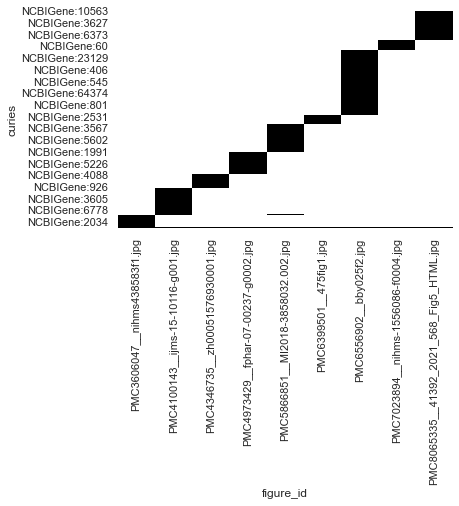

In [162]:
#as heatmap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
sns.set()
cmap = sns.mpl_palette("Blues", 2)
sns.heatmap(df, cmap=plt.get_cmap('binary'), cbar=False) # yticklabels=True
plt.show()

## BTE TRAPI Results with Selected PFOCR Figures¶

Once we have a data frame of enriched PFOCR figures, we join it with the TRAPI results data frame. The Fisher's Exact Test is run for each figure and result entity combination to identify which figure each BTE TRAPI result is most similar to. We don't cluster the TRAPI results by figure, however, because if a result is highly relevant to two figures, it can show up in both. It's more accurate to think of the figure as being a different view of the TRAPI results.